In [1]:
# Make full use of the screen
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import os
import numpy as np
import time
import pickle
import random
from nltk.tokenize import word_tokenize
from nltk.stem.snowball import SnowballStemmer
import gensim
import pandas as pd
import datetime
from tensorboardX import SummaryWriter
random.seed()

In [3]:
computer_name = os.uname()[1]
if computer_name == "wenjian-desktop":
    fr_dataset_volume = "3k"
    img_dir = "/home/wenjian/Internship/data/flickr30kentities/flickr30k-images/"  # For visualization
    
    features_dir = "/home/wenjian/Internship/data/flickr30kentities/flickr30k-feats-otani/bottom-up-feats/"
    #features_dir = "/home/wenjian/Internship/GitHubCloned/DDPN/data/flickr30k/features/bottom-up-feats-resnet101/"

    #train_image_list_filepath = "/home/wenjian/Internship/data/flickr30kentities/Multi30k/task1/image_splits/train.txt"
    #train_triple_filepath = "/home/wenjian/Internship/data/flickr30kentities/queries_extracted/train_queries_fr_1000-images.csv"
    train_triple_filepath = f"/home/wenjian/Internship/data/flickr30kentities/queries_extracted/train_queries_fr_{fr_dataset_volume}-images.csv"
    train_triple_filepath_en = "/home/wenjian/Internship/data/flickr30kentities/queries_extracted/train_queries.csv"

    val_triple_filepath = "/home/wenjian/Internship/data/flickr30kentities/queries_extracted/val_queries_fr.csv"
    test_triple_filepath = "/home/wenjian/Internship/data/flickr30kentities/queries_extracted/test_2016_flickr_queries_fr.csv"
    
    xml_dirpath = "/home/wenjian/Internship/data/flickr30kentities/annotations/Annotations/"

    project_root = "/home/wenjian/Internship/DDPN_transfer/"
    
    english_pretrained_model_path = "/home/wenjian/Internship/DDPN_transfer/pretrained-models/2019-08-17_19-26-48_L1-gt-softlabel_drop0.5_checkpoint_4_69.30.tar"
    specific_dictionary_file = "/home/wenjian/Internship/data/word_allignment/lex.e2f"  # The file name is e2f, but in fact it is f2e
    general_dictionary_file = f"/home/wenjian/Internship/DDPN_transfer/dictionary/Fr-En-GoogleTrans_dictionary{fr_dataset_volume}.txt"
    
elif computer_name == "apas":
    img_dir = "/home/wenjian/data/flickr30kentities/flickr30k-images/"  # For visualization
    
    features_dir = "/home/wenjian/data/flickr30kentities/bottom-up-feats/"
    
    #train_image_list_filepath = "/home/wenjian/data/flickr30kentities/Multi30k/task1/image_splits/train.txt"
    #train_triple_filepath = "/home/wenjian/data/flickr30kentities/queries_extracted/train_queries_fr_auto_3000.csv"
    train_triple_filepath = "/home/wenjian/Internship/data/flickr30kentities/queries_extracted/train_queries_fr_1000-images.csv"
    train_triple_filepath_en = "/home/wenjian/Internship/data/flickr30kentities/queries_extracted/train_queries.csv"

    val_triple_filepath = "/home/wenjian/data/flickr30kentities/queries_extracted/val_queries_fr.csv"

    xml_dirpath = "/home/wenjian/data/flickr30kentities/annotations/Annotations/"

    project_root = None
    
    english_pretrained_model_path = None
    dictionary_file = None
    general_dictionary_file = None
    
elif computer_name == "dongwenjian-ThinkPad-E460":
    fr_dataset_volume = "5k"
    img_dir = "/media/dongwenjian/SSDBACKUP/Internship/data/flickr30kentities/flickr30k-images/"  # For visualization
    
    features_dir = "/media/dongwenjian/SSDBACKUP/Internship/data/flickr30kentities/flickr30k-feats-otani/bottom-up-feats/"
    #features_dir = "/home/wenjian/Internship/GitHubCloned/DDPN/data/flickr30k/features/bottom-up-feats-resnet101/"

    #train_image_list_filepath = "/home/wenjian/Internship/data/flickr30kentities/Multi30k/task1/image_splits/train.txt"
    #train_triple_filepath = "/home/wenjian/Internship/data/flickr30kentities/queries_extracted/train_queries_fr_1000-images.csv"
    train_triple_filepath = f"/media/dongwenjian/SSDBACKUP/newly_added/data/flickr30kentities/queries_extracted/train_queries_fr_{fr_dataset_volume}-images.csv"
    train_triple_filepath_en = "/media/dongwenjian/SSDBACKUP/newly_added/data/flickr30kentities/queries_extracted/train_queries.csv"

    val_triple_filepath = "/media/dongwenjian/SSDBACKUP/newly_added/data/flickr30kentities/queries_extracted/val_queries_fr.csv"
    test_triple_filepath = "/media/dongwenjian/SSDBACKUP/newly_added/data/flickr30kentities/queries_extracted/test_2016_flickr_queries_fr.csv"
    
    xml_dirpath = "/media/dongwenjian/SSDBACKUP/Internship/data/flickr30kentities/annotations/Annotations/"

    project_root = "/media/dongwenjian/SSDBACKUP/newly_added/new_experiments/"
    
    english_pretrained_model_path = "/media/dongwenjian/SSDBACKUP/Internship/DDPN_transfer/pretrained-models/2019-08-17_19-26-48_L1-gt-softlabel_drop0.5_checkpoint_4_69.30.tar"
    specific_dictionary_file = "/media/dongwenjian/SSDBACKUP/Internship/data/word_allignment/lex.e2f"  # The file name is e2f, but in fact it is f2e
    general_dictionary_file = f"/media/dongwenjian/SSDBACKUP/newly_added/new_experiments/dictionary/Fr-En-GoogleTrans_dictionary{fr_dataset_volume}.txt"
    
else:
    raise Exception("Failed to initialize paths: computer not recognized")
print(computer_name)

dongwenjian-ThinkPad-E460


In [4]:
print(torch.cuda.device_count())
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
#device = torch.device("cpu")


0


In [5]:
class CFG:
    def __init__(self):
        # cfg_path for future use
        self.xml_dirpath = xml_dirpath
        self.triple_filepaths = {'train': train_triple_filepath,
                                 'val': val_triple_filepath,
                                 'test': test_triple_filepath
                                }
        self.RPN_TOPN = 100
        
        # Configure for network
        self.WORD_EMB_SIZE = 300
        self.RNN_DIM = 1024
        self.VISUAL_FEATURES = 2048  # For resnet
        self.SPATIAL_FEATURES = 5
        self.SOFTLABEL_THRESHOLD = 0.5 # 0.5 in paper
        self.GAMMA = 1
        self.DELTA = 1
        self.STEMMING = False
        self.epsilon = 1e-7
        self.dropout_rate = 0.5
        self.lr_decay_rate = 0.7
        self.initial_lr = 0.001
        #self.use_pretrained_model = False
        self.regression_loss = False
        self.transfer_learning = True
        
         
        # At the beginning those paths are not wrapped and they exist as global variables. 
        # Then in order to wrap the training, validation and test process into functions, we need to avoid global variables. 
        # Thus we begin to wrap more things into CFG.
        # It should be noticed that, the part before training are not adapted yet, thus for the following variables they may still use the original global variables
        
        # The paths 
        self.fr_dataset_volume = fr_dataset_volume
        self.img_dir = img_dir
        self.features_dir = features_dir

        self.train_triple_filepath_en = train_triple_filepath_en
        
        self.project_root = project_root 
        
        self.english_pretrained_model_path = english_pretrained_model_path
        self.general_dictionary_file = general_dictionary_file
        self.specific_dictionary_file = specific_dictionary_file
        
        # The file names to store the training process
        self.pth_filename = None
        self.checkpoint_filename_base = None
        self.process_filename = None
        self.pytorch_model_save_path = None
        self.pytorch_result_save_path = None
        self.pytorch_checkpoint_save_path = None
        self.output_root = None
        self.output_dir_name = None
        self.output_dir = None
        self.log_dir = None
        # Here we create them as None just as a reminder that those variables will be involved later. 
        
cfg = CFG()

## Establish vocabulary dictionary from training set: French   

In [6]:
train_df = pd.read_csv(train_triple_filepath)
#stemmer = SnowballStemmer("english")
corpus_list = train_df["entity_content"].values.tolist()
corpus_list = ['EMPTYWORDTOKEN', 'UNKNOWNWORD'] + corpus_list  # 'EMPTYWORDTOKEN' is the token for empty word. It is needed because the input data for word embedding layer require padding. 

if cfg.STEMMING:
    corpus = [[stemmer.stem(w) for w in word_tokenize(q, language="french")] for q in corpus_list]
else: 
    corpus = [[w.lower() for w in word_tokenize(q, language="french")] for q in corpus_list]
# corpus is a list of list of string

training_corpus_dct = gensim.corpora.Dictionary(corpus)

## Establish vocabulary dictionary from training set: English

In [7]:
train_df_en = pd.read_csv(train_triple_filepath_en)
corpus_list_en = train_df_en["entity_content"].values.tolist()
corpus_list_en = ['EMPTYWORDTOKEN', 'UNKNOWNWORD'] + corpus_list_en  # 'EMPTYWORDTOKEN' is the token for empty word. It is needed because the input data for word embedding layer require padding. 
if cfg.STEMMING:
    corpus_en = [[stemmer.stem(w) for w in word_tokenize(q)] for q in corpus_list_en]
else: 
    corpus_en = [[w.lower() for w in word_tokenize(q)] for q in corpus_list_en]
# corpus is a list of list of string

training_corpus_dct_en = gensim.corpora.Dictionary(corpus_en)
training_corpus_dct_en.__dict__

{'token2id': {'emptywordtoken': 0,
  'unknownword': 1,
  'guys': 2,
  'two': 3,
  'young': 4,
  'hair': 5,
  'shaggy': 6,
  'hands': 7,
  'their': 8,
  ',': 9,
  'males': 10,
  'white': 11,
  'bushes': 12,
  'many': 13,
  'men': 14,
  'green': 15,
  'shirts': 16,
  'a': 17,
  'man': 18,
  'blue': 19,
  'shirt': 20,
  'friends': 21,
  'several': 22,
  'hard': 23,
  'hats': 24,
  'giant': 25,
  'pulley': 26,
  'system': 27,
  'workers': 28,
  'equipment': 29,
  'of': 30,
  'piece': 31,
  'machine': 32,
  'four': 33,
  'structure': 34,
  'tall': 35,
  'three': 36,
  'large': 37,
  'rig': 38,
  'child': 39,
  'dress': 40,
  'pink': 41,
  'set': 42,
  'stairs': 43,
  'an': 44,
  'entry': 45,
  'way': 46,
  'girl': 47,
  'little': 48,
  'the': 49,
  'her': 50,
  'playhouse': 51,
  'wooden': 52,
  'someone': 53,
  'hat': 54,
  'stair': 55,
  'window': 56,
  'ladder': 57,
  'building': 58,
  'jeans': 59,
  'windows': 60,
  'one': 61,
  'gray': 62,
  'black': 63,
  'stove': 64,
  'guy': 65,
  '

## Data Generation

In [8]:
from torch.utils import data
import pandas as pd
import xml.etree.ElementTree as ET

class DDPNDataset(data.Dataset):
    'Characterizes a dataset for PyTorch'
    def __init__(self, cfg, phase):
        'Initialization'
        #self.labels = labels
        #self.list_IDs = list_IDs
        self.cfg = cfg
        self.phase = phase
        self.df_triple = pd.read_csv(self.cfg.triple_filepaths[self.phase])  # Triple means (image, ground_truth_bounding_box, query)
        

    def __len__(self):
        'Denotes the total number of samples'
        return len(self.df_triple.index)

    def __getitem__(self, index):
        'Generates one sample of data'
        # Select sample
        imageID = str(self.df_triple.iloc[index]["imgId"])
        entityID = str(self.df_triple.iloc[index]["entityId"])
        
        # Load data and get label
        # X = torch.load('data/' + ID + '.pt')
        # X should be all the inputs, include visual features and text query
        zf = np.load(features_dir+imageID+'.jpg.npz')
        num_bbox = zf['num_bbox']
        visual_feat = zf['x']  # visual_feat's shape here is supposed to be (2048, num_bbox) for resnet, (4096, num_bbox) for vgg16
        visual_feat = np.transpose(visual_feat) # now (num_bbox, 2048) for resnet, (num_bbox, 4096) for vgg16
        spatial_feat = zf['bbox'] # spatial_feat's shape here is supposed to be (num_bbox, 4)
        x1 = spatial_feat[:,0]
        y1 = spatial_feat[:,1]
        x2 = spatial_feat[:,2]
        y2 = spatial_feat[:,3]
        image_w = zf['image_w']
        image_h = zf['image_h']
        spatial_feat = np.column_stack((x1/image_w, y1/image_h, x2/image_w, y2/image_h, (x2-x1)*(y2-y1)/(image_w*image_h)))
        
        # Concatenate visual features and spatial features
        X = np.column_stack((visual_feat, spatial_feat))
        
        # If there are fewer than self.cfg.RPN_TOPN=100 proposals, add 0 rows below
        for i in range(X.shape[0], self.cfg.RPN_TOPN):
            zero_row = np.zeros((1,X.shape[1]))
            X = np.vstack((X, zero_row))
        # Convert numpy array to torch tensor 
        X = torch.from_numpy(X)
        X = X.float()
        
        query = self.df_triple.iloc[index]["entity_content"]
        
        # Get ground truth bounding box
        gt_bbox = self._get_bounding_box(imageID, entityID) # gt_bbox is a triple in format (x1, y1, x2, y2)
        # Get the bounding box boundary regard as image size
        gt_bbox[0] /= float(image_w)
        gt_bbox[2] /= float(image_w)
        gt_bbox[1] /= float(image_h)
        gt_bbox[3] /= float(image_h)
        # Convert list to torch tensor
        gt_bbox = torch.tensor(gt_bbox) 
        
        additional_info = (imageID, entityID, image_w, image_h) # those info are not directly used in training, but used in visualization

        return (X, query), gt_bbox, additional_info  
    
    def _get_bounding_box(self, image_id, object_id): # image_id and object_id are expected to be string
         
        xml_tree = ET.parse(self.cfg.xml_dirpath + image_id + '.xml')
        root = xml_tree.getroot()
        boxes = []  # To deal with one object, multiple bounding boxes
        for obj in root.findall('object'):
            for name in obj.findall('name'):
                if name.text == object_id:
                    bndbox = obj.find("bndbox")
                    x1 = int(bndbox.find("xmin").text)
                    y1 = int(bndbox.find("ymin").text)
                    x2 = int(bndbox.find("xmax").text)
                    y2 = int(bndbox.find("ymax").text)
                    
                    boxes.append([x1, y1, x2, y2])
        if len(boxes)==0:
            raise Exception("Entity not found. Image id: "+image_id+", Entity id: "+object_id)
        boxes_array = np.array(boxes)
        # When there are multiple bounding boxes, draw the minimum box which contains all these invidual boxes
        x1 = np.min(boxes_array[:,0])
        y1 = np.min(boxes_array[:,1])
        x2 = np.max(boxes_array[:,2])
        y2 = np.max(boxes_array[:,3])
                    
        return [x1, y1, x2, y2]        

In [9]:
training_set = DDPNDataset(cfg, 'train')
validation_set = DDPNDataset(cfg, 'val')
test_set = DDPNDataset(cfg, 'test')

### Calculate IoU score between two boxes

In [10]:
def intersect(box_a, box_b):  # Tackle with N (like 100) box pairs at the same time
    inter_xmin=torch.max(box_a[:,:,0], box_b[:,:,0])
    inter_xmax=torch.min(box_a[:,:,2], box_b[:,:,2])
    inter_ymin=torch.max(box_a[:,:,1], box_b[:,:,1])
    inter_ymax=torch.min(box_a[:,:,3], box_b[:,:,3])
    inter = torch.max((inter_xmax-inter_xmin).float(), torch.tensor(0).float().to(box_a.device)) * torch.max((inter_ymax-inter_ymin).float(), torch.tensor(0).float().to(box_a.device))
    return inter

In [11]:
# https://github.com/amdegroot/ssd.pytorch/blob/master/layers/box_utils.py#L48
def IoU(box_a, box_b):  # Tackle with N (like 100) box pairs at the same time
    # The shape of each input: (batch_size, box_number_in_each_image, 4)
    box_a = box_a.float() 
    box_b = box_b.float()
    inter = intersect(box_a, box_b)
    area_a = (box_a[:,:,2] - box_a[:,:,0]) * (box_a[:,:,3] - box_a[:,:,1])
    area_b = (box_b[:,:,2] - box_b[:,:,0]) * (box_b[:,:,3] - box_b[:,:,1])
    union = area_a + area_b - inter
    return inter.float() / union.float()

### Calculate softlable

In [12]:
def get_softlabel_wrapper(threshold, epsilon):
    def get_softlable(X, gt_bbox): # gt_bbox is expected as a triple in format (x1, y1, x2, y2). All the four boundaries are between 0 and 1. Batch is not considered here
        # X is expected in shape (batch_size, N, 2053). We use the 4 columns with indexes 2047-2051. It should be noted that the last column in X is the area so we should not use it. 
        # gt_bbox is expected in format tensor with shape (batch_size, 4)
        gt_bbox = gt_bbox.unsqueeze(1)
        iou = IoU(X[:,:,-5:-1], gt_bbox.repeat((1,cfg.RPN_TOPN,1)))   #.double()
        iou_with_threshold = iou*(iou>threshold).float()
        # iou_with_threshold size is (64, 100)
        denominator = iou_with_threshold.sum(dim=1).unsqueeze(1) + epsilon
        #iou_with_threshold denominator size is (64, 1)
        iou_with_threshold_l1_norm = iou_with_threshold / denominator
        return iou_with_threshold_l1_norm
    return get_softlable
get_softlable = get_softlabel_wrapper(cfg.SOFTLABEL_THRESHOLD, torch.tensor(cfg.epsilon).to(device)) 

### Loss function

In [13]:
def loss_wrapper(cfg, loggers_dct=None):
    # loggers_dct are to log the training process
    def my_loss(predict, target):  # predict is expected to be (s,t), target their ground truth value
        s, t = predict
        gt_s, gt_t = target
        s = torch.add(s, torch.tensor(cfg.epsilon))  # In order to avoid 0 in the denominator

        loss_ranking = F.kl_div(torch.log(s), gt_s, reduction='batchmean') 
        if loggers_dct != None:
            loggers_dct['logger'].add_scalar("ranking_loss", loss_ranking, my_loss.counter)
        if cfg.regression_loss:
            N = t.size()[1]

            loss_regression = F.smooth_l1_loss(t, gt_t.unsqueeze(1).repeat(1,N,1), reduction='mean')

            if loggers_dct != None:
                loggers_dct['logger'].add_scalar("regression_loss", cfg.GAMMA*loss_regression, my_loss.counter)
        my_loss.counter += 1 
        
        if cfg.regression_loss:
            #return delta*loss_ranking + loss_regression
            return loss_ranking + cfg.GAMMA*loss_regression
        else:
            return loss_ranking 
    my_loss.counter = 0
    return my_loss
loss_func = loss_wrapper(cfg)  # This function doesn't contain loggers. It is used for testing. 
# Before training, another loss_func should be created with loggers

In [14]:
class DDPN(torch.nn.Module):
    def __init__(self, cfg, vocab_size=None, embedding_weights=None):
        super(DDPN, self).__init__()
        self.cfg = cfg
        if type(embedding_weights) == type(None):
            #print("type(embedding_weights) equals to type(None)")
            assert isinstance(vocab_size, int), "Error: you are using non-pretraind embedding, and vocab_size is not an integer, but {}.".format(vocab_size)
            self.embedding = nn.Embedding(vocab_size, self.cfg.WORD_EMB_SIZE)  
            self.embedding.requires_grad = True
        else:
            #print("type(embedding_weights) doesn't equal to type(None)")
            self.embedding = nn.Embedding(embedding_weights.size()[0], embedding_weights.size()[1])
            self.embedding.load_state_dict({'weight': embedding_weights})
            self.embedding.requires_grad = False
        self.lstm = nn.LSTM(self.cfg.WORD_EMB_SIZE, self.cfg.RNN_DIM)  # This lstm is batch_first=false
        self.fc1 = nn.Linear(self.cfg.VISUAL_FEATURES+self.cfg.SPATIAL_FEATURES+self.cfg.RNN_DIM, 512)
        # Pytorch's Linear layer automatically exerts on the last dimension of the tensor, so we don't need to take care of N=100 manually. 
        self.fc_rank = nn.Linear(512,1)
        if cfg.regression_loss:
            self.fc_regression = nn.Linear(512,4)
        self.batchnorm = torch.nn.BatchNorm1d(512)
        self.dropout = nn.Dropout(cfg.dropout_rate)
        self.softmax = nn.Softmax(dim=1)
        
        if cfg.transfer_learning:
            self.frozen_layers = []
            #self.frozen_layers = [self.embedding, self.lstm, self.fc1, self.fc_rank]
            #self.frozen_layers = [self.lstm, self.fc1, self.fc_rank]
            #self.frozen_layers = [self.fc1, self.fc_rank]
            #self.frozen_layers = [self.fc_rank]
            for frozen_layer in self.frozen_layers:
                for param in frozen_layer.parameters():
                    param.requires_grad = False
        
        
    def forward(self, Xs, queries, seq_lengths):
        
        # one piece of query here should be a 1d tensor of indices (index of each word in the corpus dictionary) 
        # queries is a batch of query
        # seq_lengths is the length of each query
        
        batch_size = Xs.size()[0]
        
        emb = self.embedding(queries) # emb size is (time_sequence, batch_size, 300)
        # self.tanh = ...
        emb_packed = torch.nn.utils.rnn.pack_padded_sequence(emb, lengths=seq_lengths, batch_first=False, enforce_sorted=False)
        qs = self.lstm(emb_packed)[0] # [0] is to choose the output h_t sequence
        # qs.size() is (time_sequence, batch_size, 1024)
        qs_unpacked, qs_len = torch.nn.utils.rnn.pad_packed_sequence(qs, batch_first=False)
        qs_unpacked_batch_first = qs_unpacked.permute(1,0,2)
        q = qs_unpacked_batch_first[torch.arange(batch_size),qs_len-1] # to choose the output feature of last word
        
        q_tiled = q.unsqueeze(1).repeat((1,self.cfg.RPN_TOPN,1)) 

        x_concat = torch.cat((Xs, q_tiled), dim=2)  # x_concat's shape is expected as (batch_size, 100, 2053+1024)
        x1_linear = self.fc1(x_concat) 
        x1 = F.relu(x1_linear)
        x1 = x1.permute(0,2,1)
        x1 = self.batchnorm(x1)
        x1 = x1.permute(0,2,1)
        x1_dropped = self.dropout(x1)
        # x1's shape is expected as (batch_size, 100, 512)
        s0 = self.fc_rank(x1_dropped).squeeze()  # s's shape is expected to be (batch_size, 100)
        s = self.softmax(s0)
        if cfg.regression_loss:
            t = self.fc_regression(x1_dropped)
            return (s, t)
        else:
            return (s, None)

In [15]:
def preprocess_query(queries, training_corpus_dct):  
    # queries is a tuple of strings. The length of queries is the batch size. 
    
    tokenized_sentence_to_indices = training_corpus_dct.doc2idx
    
    if cfg.STEMMING:
        indices = [tokenized_sentence_to_indices([stemmer.stem(w) for w in word_tokenize(q, language="french")]) for q in queries]
    else:
        indices = [tokenized_sentence_to_indices([w.lower() for w in word_tokenize(q, language="french")]) for q in queries]

    # Gensim assign -1 to unknown word in the dictionary. 
    # Pytorch embedding, however, don't support negative index. 
    # So we kept 1 for unknown word when building Gensim dictionary, and convert -1 to 1 now
    indices = [[idx if idx!=-1 else 1 for idx in row] for row in indices]
                
#     # Word order shuffle test:
#     for row in indices:
#         random.shuffle(row) 
    

    seq_lengths = [len(row) for row in indices]
    
    Qs_before_padding = [torch.tensor(row) for row in indices]

    padding_value = 0

    
    Qs = nn.utils.rnn.pad_sequence(Qs_before_padding, batch_first=False, padding_value=padding_value)
    
    return Qs, seq_lengths
    

In [16]:
def calculate_IoU_scores_wrapper(cfg):
    def calculate_IoU_scores(Xs, pred, gt_bboxes):
        s, t = pred
        proposal_chosen = torch.argmax(s, dim=1)
        batch_size = Xs.size()[0]
        gt_bboxes = gt_bboxes.unsqueeze(1) # add a dimension 1 at the middle is to use the function IoU
        bboxes_chosen_original = Xs[torch.arange(batch_size),proposal_chosen,-5:-1].unsqueeze(1)
        ious_original = IoU(bboxes_chosen_original, gt_bboxes).squeeze()
        if cfg.regression_loss:
            bboxes_chosen_refined = t[torch.arange(batch_size),proposal_chosen,:].unsqueeze(1)
            ious_refined = IoU(bboxes_chosen_refined, gt_bboxes).squeeze()
            return ious_original, ious_refined
        return ious_original
    return calculate_IoU_scores
calculate_IoU_scores = calculate_IoU_scores_wrapper(cfg)

## Training from scratch

In [18]:
# en_vocab = len(training_corpus_dct_en.token2id)
# fr_vocab = len(training_corpus_dct.token2id)

# print("Non-pretrained embedding is used.")
# model = DDPN(cfg, vocab_size=len(training_corpus_dct.token2id))

# mapping_method_name = 'training_from_scratch'

Non-pretrained embedding is used.


## Load and map the embedding matrix

### Init model

In [17]:
def prepare_model_for_transfer(training_corpus_dct, training_corpus_dct_en, english_pretrained_model_path, cfg):
    en_vocab = len(training_corpus_dct_en.token2id)
    fr_vocab = len(training_corpus_dct.token2id)

    model = DDPN(cfg, vocab_size=fr_vocab)
    model_en = DDPN(cfg, vocab_size=en_vocab)

    #model_en.load_state_dict(torch.load(english_pretrained_model_path, map_location=device))
    checkpoint = torch.load(english_pretrained_model_path, map_location=device)

    if not cfg.regression_loss:  # In case of the pretrained model has regression loss while transfering model doesn't
        try:
            checkpoint['model_state_dict'].pop("fc_regression.weight")
            checkpoint['model_state_dict'].pop("fc_regression.bias")
        except KeyError:
            pass

    model_en.load_state_dict(checkpoint['model_state_dict'])

    

    pretrained_dict = model_en.state_dict()
    model_dict = model.state_dict()

    # 1. filter out unnecessary keys
    pretrained_dict = {k: v for k, v in pretrained_dict.items() if k != "embedding.weight"}
    # 2. overwrite entries in the existing state dict
    model_dict.update(pretrained_dict) 
    # 3. load the new state dict
    #model.load_state_dict(model_dict)
    
    return model, model_en, model_dict

In [18]:
# model, model_en, model_dict = prepare_model_for_transfer(training_corpus_dct, 
#                                                         training_corpus_dct_en, 
#                                                         english_pretrained_model_path, 
#                                                         cfg)

### Embedding mapping

#### Random mapping

In [19]:
def transfer_with_random_mapping(model, model_en, model_dict, training_corpus_dct, training_corpus_dct_en, cfg):
    fr_vocab = len(training_corpus_dct.token2id)
    en_vocab = len(training_corpus_dct_en.token2id)
    
    emb_en = model_en.state_dict()["embedding.weight"]
    emb_fr = torch.zeros((fr_vocab, cfg.WORD_EMB_SIZE))
    
    for i in range(fr_vocab):
        emb_fr[i,:] = emb_en[random.randint(0, en_vocab-1),:]

    model_dict.update({"embedding.weight":emb_fr}) 
    model.load_state_dict(model_dict)
    

In [42]:
# transfer_with_random_mapping(model, model_en, model_dict, training_corpus_dct, training_corpus_dct_en, cfg)
# mapping_method_name = 'random-mapping'

#### frequency mapping

In [20]:
def transfer_with_frequency_mapping(model, model_en, model_dict, training_corpus_dct, training_corpus_dct_en, cfg):
    fr_vocab = len(training_corpus_dct.token2id)
    
    emb_en = model_en.state_dict()["embedding.weight"]
    emb_fr = torch.zeros((fr_vocab, cfg.WORD_EMB_SIZE))
    
    freq_list_fr = vocab_list_sorted_by_freq(training_corpus_dct.dfs)
    freq_list_en = vocab_list_sorted_by_freq(training_corpus_dct_en.dfs)
    
    for i in range(fr_vocab):
        emb_fr[freq_list_fr[i][0],:] = emb_en[freq_list_en[i][0],:]

    model_dict.update({"embedding.weight":emb_fr}) 
    model.load_state_dict(model_dict)

In [39]:
# transfer_with_frequency_mapping(model, model_en, model_dict, training_corpus_dct, training_corpus_dct_en, cfg)
# mapping_method_name = 'frequency-mapping'

#### General dictionary mapping

In [21]:
def transfer_with_general_dictionary_mapping(model, model_en, model_dict, training_corpus_dct, training_corpus_dct_en, general_dictionary_file, cfg):
    with open(general_dictionary_file, 'r') as f:
        dictionary_file_content = f.readlines()

    fr_to_english_dict = {}
    for line in dictionary_file_content:
        parts = line[:-1].split(' ')  # line example: 'garçons boys\n'
        fr_to_english_dict[parts[0]] = parts[1]
        
        
    fr_vocab = len(training_corpus_dct.token2id)
    en_vocab = len(training_corpus_dct_en.token2id)
    emb_en = model_en.state_dict()["embedding.weight"]
    emb_fr = torch.zeros((fr_vocab, cfg.WORD_EMB_SIZE))

    for i in range(fr_vocab):
        fr_word = training_corpus_dct[i]
        if fr_word in fr_to_english_dict:
            en_word = fr_to_english_dict[fr_word]  
            if en_word in training_corpus_dct_en.token2id:
                en_word_id = training_corpus_dct_en.token2id[en_word]
                emb_fr[i,:] = emb_en[en_word_id,:]
            else: # the most probable English word doesn't appear in the training corpus, then assign a word vector randomly
                emb_fr[i,:] = emb_en[random.randint(0, en_vocab-1),:]
        else:  # the French word is not included in the dictionary, then assign a word vector randomly
            emb_fr[i,:] = emb_en[random.randint(0, en_vocab-1),:]

    model_dict.update({"embedding.weight":emb_fr}) 
    model.load_state_dict(model_dict)

In [63]:
# transfer_with_general_dictionary_mapping(model, model_en, model_dict, training_corpus_dct, training_corpus_dct_en, general_dictionary_file, cfg)
# mapping_method_name = 'general-dictionary-mapping'

#### data-specific dictionary mapping

In [22]:
def transfer_with_specific_dictionary_mapping(model, model_en, model_dict, training_corpus_dct, training_corpus_dct_en, specific_dictionary_file, cfg):
    with open(specific_dictionary_file, 'r') as f:
        dictionary_file_content = f.readlines()

    fr_to_english_dict = {}
    for line in dictionary_file_content:
        parts = line[:-1].split(' ')  # line example: 'focus intérêt 1.0000000\n'
        if parts[1] in fr_to_english_dict:
            fr_to_english_dict[parts[1]].append((parts[0], float(parts[2]))) 
        else:
            fr_to_english_dict[parts[1]] = [(parts[0], float(parts[2])),]
    
    fr_vocab = len(training_corpus_dct.token2id)
    en_vocab = len(training_corpus_dct_en.token2id)
    emb_en = model_en.state_dict()["embedding.weight"]
    emb_fr = torch.zeros((fr_vocab, cfg.WORD_EMB_SIZE))

    from operator import itemgetter
    emb_fr = torch.zeros((fr_vocab, cfg.WORD_EMB_SIZE))
    for i in range(fr_vocab):
        fr_word = training_corpus_dct[i]
        if fr_word in fr_to_english_dict:
            en_words = fr_to_english_dict[training_corpus_dct[i]] 
            most_probable_word = max(en_words ,key=itemgetter(1))[0] 
            if most_probable_word in training_corpus_dct_en.token2id:
                most_probable_word_id = training_corpus_dct_en.token2id[most_probable_word]
                emb_fr[i,:] = emb_en[most_probable_word_id,:]
            else: # the most probable English word doesn't appear in the training corpus, then assign a word vector randomly
                emb_fr[i,:] = emb_en[random.randint(0, en_vocab-1),:]
        else:  # the French word is not included in the dictionary, then assign a word vector randomly
            emb_fr[i,:] = emb_en[random.randint(0, en_vocab-1),:]

    model_dict.update({"embedding.weight":emb_fr}) 
    model.load_state_dict(model_dict)

In [39]:
# transfer_with_specific_dictionary_mapping(model, model_en, model_dict, training_corpus_dct, training_corpus_dct_en, specific_dictionary_file, cfg)
# mapping_method_name = 'specific-dictionary-mapping'

## Functions to train and test the model 

In [23]:
def train_epoch(model, training_generator, optimizer, epoch, device, cfg, process, loggers_dct, train_losses):
    # Training
    
    train_losses_by_epoch = []
    train_loss_average_by_epoch = 0.0
    
    # For statistics of IoU score
    train_all_ious_original = []
    train_all_ious_refined = []
    
    for train_batch_counter, (inputs, gt_bboxes, _) in enumerate(training_generator):
        
        model.train()
        
        optimizer.zero_grad()
        
        Xs, queries = inputs
        # queries is a tuple of strings. The length of queries is the batch size. 
        
        Qs, seq_lengths = preprocess_query(queries, training_corpus_dct)
        # len(seq_lengths) equals to batch_size

        Xs, Qs, gt_bboxes = Xs.to(device), Qs.to(device), gt_bboxes.to(device)
        
        pred = model(Xs, Qs, seq_lengths)
        targ = (get_softlable(Xs, gt_bboxes), gt_bboxes)
        loss = loss_func(pred, targ)
        
        train_losses_by_epoch.append(loss.item())
        train_loss_average_by_epoch += loss.item()*Xs.size(0)
        
        loss.backward()
        optimizer.step()
        
        
        print(f"\repoch {epoch}, training phase, batch {train_batch_counter}/{len(training_generator)}, loss={loss.item()}", end='')
        loggers_dct['logger'].add_scalar("train_loss_by_batch", loss.item(), train_epoch.counter)
        
        # statistics of IoU score
        if cfg.regression_loss:
            ious_original, ious_refined = calculate_IoU_scores(Xs, pred, gt_bboxes)
        else:
            ious_original = calculate_IoU_scores(Xs, pred, gt_bboxes)
        
        train_all_ious_original = train_all_ious_original + ious_original.tolist()
        if cfg.regression_loss:
            train_all_ious_refined = train_all_ious_refined + ious_refined.tolist()
        
        train_epoch.counter += 1
        
        
    train_losses.append(train_losses_by_epoch)
    train_loss_average_by_epoch /= len(training_generator.dataset)
    print("\repoch", epoch, ", training phase finished, average loss:",train_loss_average_by_epoch)
    loggers_dct['train_logger'].add_scalar("average_loss_by_epoch", train_loss_average_by_epoch, epoch)
    
    # For statistics of IoU score
    train_good_original = torch.tensor(train_all_ious_original) > 0.5     
    train_acc_original = train_good_original.sum().float()/len(training_set)
    print("\tTraining: accuracy based on original bounding box:", train_acc_original.item())
    loggers_dct['train_iou_before_refinement_logger'].add_scalar("IoU_accuracy", train_acc_original, epoch)

    if cfg.regression_loss:
        train_good_refined = torch.tensor(train_all_ious_refined) > 0.5
        train_acc_refined = train_good_refined.sum().float()/len(training_set)
        print("\tTraining: accuracy of refined bounding box:", train_acc_refined.item())
        loggers_dct['train_iou_after_refinement_logger'].add_scalar("IoU_accuracy", train_acc_refined, epoch)
    
    
    # The following information is added once in each epoch
    process['train_average_losses_by_epoch'].append(train_loss_average_by_epoch)
    process['train_IoU_acc_before_refinement'].append(train_acc_original)
    if cfg.regression_loss:
            process['train_IoU_acc_after_refinement'].append(train_acc_refined)

In [24]:
def val_epoch(model, validation_generator, epoch, device, cfg, process, loggers_dct, val_losses):
    # Validation
    val_losses_by_epoch = []
    val_loss_average_by_epoch = 0.0
    
    # For statistics of IoU score
    val_all_ious_original = []
    if cfg.regression_loss:
        val_all_ious_refined = []
    
    with torch.no_grad():      
        for val_batch_counter, (inputs, gt_bboxes, _) in enumerate(validation_generator):
            Xs, queries = inputs
           
            Qs, seq_lengths = preprocess_query(queries, training_corpus_dct)
            
            model.eval()
            
            Xs, Qs, gt_bboxes = Xs.to(device), Qs.to(device), gt_bboxes.to(device)
            
            val_pred = model(Xs, Qs, seq_lengths)
            val_targ = (get_softlable(Xs, gt_bboxes), gt_bboxes)

            val_loss = loss_func(val_pred, val_targ)

            val_losses_by_epoch.append(val_loss.item())
            val_loss_average_by_epoch += val_loss.item()*Xs.size(0)
        
            print(f"\repoch {epoch}, validation phase, batch {val_batch_counter}/{len(validation_generator)}, val_loss={val_loss.item()}", end='')
            loggers_dct['logger'].add_scalar("val_loss_by_batch", val_loss.item(), val_epoch.counter)
            
            # Statistics of IoU score
            if cfg.regression_loss:
                ious_original, ious_refined = calculate_IoU_scores(Xs, val_pred, gt_bboxes)
            else:
                ious_original = calculate_IoU_scores(Xs, val_pred, gt_bboxes)
            val_all_ious_original = val_all_ious_original + ious_original.tolist()
            if cfg.regression_loss:
                val_all_ious_refined = val_all_ious_refined + ious_refined.tolist()
            
            val_epoch.counter += 1
    
    
    val_losses.append(val_losses_by_epoch)
    val_loss_average_by_epoch /= len(validation_generator.dataset)
    print("\repoch", epoch, ", validation phase finished, average loss:",val_loss_average_by_epoch)
    loggers_dct['val_logger'].add_scalar("average_loss_by_epoch", val_loss_average_by_epoch, epoch)
    
    # For statistics of IoU score
    val_good_original = torch.tensor(val_all_ious_original) > 0.5     
    val_acc_original = val_good_original.sum().float()/len(validation_set)
    print("\tValidation: accuracy based on original bounding box:", val_acc_original.item())
    loggers_dct['val_iou_before_refinement_logger'].add_scalar("IoU_accuracy", val_acc_original, epoch)

    if cfg.regression_loss:
        val_good_refined = torch.tensor(val_all_ious_refined) > 0.5
        val_acc_refined = val_good_refined.sum().float()/len(validation_set)
        print("\tValidation: accuracy of refined bounding box:", val_acc_refined.item())
        loggers_dct['val_iou_after_refinement_logger'].add_scalar("IoU_accuracy", val_acc_refined, epoch)  
    
    process['val_average_losses_by_epoch'].append(val_loss_average_by_epoch)
    process['val_IoU_acc_before_refinement'].append(val_acc_original)
    if cfg.regression_loss:
        process['val_IoU_acc_after_refinement'].append(val_acc_refined)

In [25]:
def fit(model, 
        training_generator, 
        validation_generator, 
        optimizer, 
        device, 
        cfg, 
        max_epochs, 
        LR_scheduler, 
        process, 
        loggers_dct):
    time_start_all = time.time()
    loss = None
    train_epoch.counter = 0
    val_epoch.counter = 0
    
    train_losses = []  # This list will store the loss of all batches in all epochs
    val_losses = []

    for epoch in range(max_epochs):
        time_start = time.time()
        
        #  ----------Training-----------
        train_epoch(model, training_generator, optimizer, epoch, device, cfg, process, loggers_dct, train_losses)
        
        #  ----------Validation-----------
        val_epoch(model, validation_generator, epoch, device, cfg, process, loggers_dct, val_losses)
        
        
        # ---------------- The work after validation in each epoch -----------    
    
        LR_scheduler.step() # Decay the learning rate every epoch

        time_end = time.time()
        time_epoch = time_end - time_start
        print(f"epoch {epoch} finished. Time used: {time_epoch}")

        model.eval() # Do this before saving the model when dropout or batch normalization is involved. https://pytorch.org/tutorials/beginner/saving_loading_models.html
        # Save model's learnable parameters
        torch.save(model.state_dict(), os.path.join(cfg.pytorch_model_save_path, cfg.pth_filename))
        # Save checkpoint
        torch.save({
                    'epoch': epoch,
                    'model_state_dict': model.state_dict(),
                    'optimizer_state_dict': optimizer.state_dict(),
                    'loss': loss,

                    }, os.path.join(cfg.pytorch_checkpoint_save_path, (cfg.checkpoint_filename_base+str(epoch)+'.tar')))

        # Save loss (value) evolution
        process['train_losses'] = train_losses
        process['val_losses'] = val_losses
        

        process['time'].append(time_epoch)
        with open(os.path.join(cfg.pytorch_result_save_path, cfg.process_filename), 'wb') as fp:
            pickle.dump(process, fp)

        # the vocabulary dictionary also needs saving in the future
    
    time_end_all = time.time()
    time_total = time_end_all - time_start_all
    print(f"total time: {time_total}")
    process["total_time"] = time_total

    with open(os.path.join(cfg.pytorch_result_save_path, cfg.process_filename), 'wb') as fp:
        pickle.dump(process, fp)

In [26]:
def test(process, test_generator, cfg):
    val_iou_evolution = [elt.item() for elt in process['val_IoU_acc_before_refinement']]
    val_iou_evolution_array = np.array(val_iou_evolution)
    epoch_chosen = np.argmax(val_iou_evolution_array)
    print("epoch_chosen:", epoch_chosen)

    fr_vocab = len(training_corpus_dct.token2id)
    model_test = DDPN(cfg, vocab_size=fr_vocab)

    #model_en.load_state_dict(torch.load(english_pretrained_model_path, map_location=device))
    model_to_test_path = os.path.join(cfg.output_dir, f"checkpoint_{epoch_chosen}.tar")
    checkpoint = torch.load(model_to_test_path, map_location=device)
    model_test.load_state_dict(checkpoint['model_state_dict'])

    print("loaded checkpoint:", model_to_test_path)
    model_test.to(device)

    # For statistics of IoU score on test set
    test_all_ious_original = []
    if cfg.regression_loss:
        test_all_ious_refined = []

    print(f"Evaluating on test set: {len(test_set)} samples..." )
    with torch.no_grad():      
        for test_batch_counter, (inputs, gt_bboxes, _) in enumerate(test_generator):
            Xs, queries = inputs

            Qs, seq_lengths = preprocess_query(queries, training_corpus_dct)

            model_test.eval()

            Xs, Qs, gt_bboxes = Xs.to(device), Qs.to(device), gt_bboxes.to(device)

            test_pred = model_test(Xs, Qs, seq_lengths)
            test_targ = (get_softlable(Xs, gt_bboxes), gt_bboxes)

            # Statistics of IoU score
            if cfg.regression_loss:
                ious_original, ious_refined = calculate_IoU_scores(Xs, test_pred, gt_bboxes)
            else:
                ious_original = calculate_IoU_scores(Xs, test_pred, gt_bboxes)
            test_all_ious_original = test_all_ious_original + ious_original.tolist()
            if cfg.regression_loss:
                test_all_ious_refined = test_all_ious_refined + ious_refined.tolist()

        good_original = torch.tensor(test_all_ious_original) > 0.5     
        print("Test set: good bounding box based on original bounding box:", good_original.sum().item())
        acc_original = good_original.sum().float()/len(test_set)
        print("Test set: accuracy based on original bounding box:", acc_original.item())
    
    return acc_original.item()

In [27]:

def prepare_for_savings_and_log(run_comment, cfg):
    '''
    Notice that cfg is modified inside the function.
    The directories are created inside the function
    '''

    moment = datetime.datetime.now()
    run_name = str(moment.date()) + f"_{moment.hour}-{moment.minute}-{moment.second}" + run_comment


    cfg.output_root = os.path.join(cfg.project_root, "experiments1/") # Set here the name of the folder for log files
    cfg.output_dir_name = run_name  
    cfg.output_dir = os.path.join(cfg.output_root, cfg.output_dir_name)
    if not os.path.exists(cfg.output_dir):
        os.mkdir(cfg.output_dir)
    cfg.pytorch_model_save_path = cfg.output_dir
    cfg.pytorch_result_save_path = cfg.output_dir
    cfg.pytorch_checkpoint_save_path = cfg.output_dir


    cfg.log_dir = os.path.join(cfg.output_dir, "log")
    os.mkdir(cfg.log_dir)
    print(cfg.output_dir)

    loggers_dct = {}
    loggers_dct['logger'] = SummaryWriter(cfg.log_dir)  
    loggers_dct['train_logger'] = SummaryWriter(os.path.join(cfg.log_dir, "training"))
    loggers_dct['val_logger'] = SummaryWriter(os.path.join(cfg.log_dir, "validation"))
    loggers_dct['train_iou_before_refinement_logger'] = SummaryWriter(os.path.join(cfg.log_dir, "train_iou_before_refinement"))
    loggers_dct['val_iou_before_refinement_logger'] = SummaryWriter(os.path.join(cfg.log_dir, "val_iou_before_refinement"))
    if cfg.regression_loss:
        loggers_dct['train_iou_after_refinement_logger'] = SummaryWriter(os.path.join(cfg.log_dir, "train_iou_after_refinement"))
        loggers_dct['val_iou_after_refinement_logger'] = SummaryWriter(os.path.join(cfg.log_dir, "val_iou_after_refinement"))

    cfg.pth_filename = "ddpn.pth"
    cfg.checkpoint_filename_base = "checkpoint_"  # eg. checkpoint_3.tar means the chechpoint after epoch=3
    cfg.process_filename = "process.dct" # .dct here simply means saving a dictionary in binary mode by pickle
    
    return loggers_dct

## Start training and then test

In [ ]:

experiment_number = 1 

accuracies_on_test_set = []

mode = 'general-dictionary-mapping'

for experiment_index in range(experiment_number):
    
    print(f'============== The experiment No.{experiment_index} starts ==================')

    
    # ---------------Initialize model------------------
    if mode == 'training-from-scratch':

        print("Non-pretrained embedding is used.")
        model = DDPN(cfg, vocab_size=len(training_corpus_dct.token2id))

            
    elif mode == 'training-from-scratch-except-embedding':
        model, model_en, model_dict = prepare_model_for_transfer_no_transfer_learning(training_corpus_dct, 
                                                            training_corpus_dct_en, 
                                                            english_pretrained_model_path, 
                                                            cfg)

    else: 
        model, model_en, model_dict = prepare_model_for_transfer(training_corpus_dct, 
                                                            training_corpus_dct_en, 
                                                            english_pretrained_model_path, 
                                                            cfg)

        if mode == 'random-mapping':
            transfer_with_random_mapping(model, model_en, model_dict, training_corpus_dct, training_corpus_dct_en, cfg)

        elif mode == 'frequency-mapping':
            transfer_with_frequency_mapping(model, model_en, model_dict, training_corpus_dct, training_corpus_dct_en, cfg)

        elif mode == 'general-dictionary-mapping':
            transfer_with_general_dictionary_mapping(model, model_en, model_dict, training_corpus_dct, training_corpus_dct_en, general_dictionary_file, cfg)

        elif mode == 'specific-dictionary-mapping':
            transfer_with_specific_dictionary_mapping(model, model_en, model_dict, training_corpus_dct, training_corpus_dct_en, specific_dictionary_file, cfg)

        else:
            raise Exception('unknown mapping mode')
    mapping_method_name = mode
    
    
    #-----------------Prepare for training------------------
    # Parameters
    params = {'batch_size': 64,
              'num_workers': 1}

    training_generator = data.DataLoader(training_set, shuffle=True, **params)
    validation_generator = data.DataLoader(validation_set, shuffle=True, **params)
    test_generator = data.DataLoader(test_set, shuffle=True, **params)


    run_comment = "_5k_all-trainable_" + mapping_method_name
    #run_comment = "_5k_random-word-order_all-trainable_" + mapping_method_name
    #run_comment = "_5k_freeze-fc_rank_" + mapping_method_name
    loggers_dct = prepare_for_savings_and_log(run_comment, cfg)


    model.to(device)

    loss_func = loss_wrapper(cfg, loggers_dct)

    optimizer = torch.optim.Adam(model.parameters(), betas=(0.9, 0.999), lr=0.001) 
    LR_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=cfg.lr_decay_rate)
    # Warning: Pytorch's Adam does not have the learning rate decay feature. 
    #          Possibly learning rate scheduler may achieve the same effect. 
    # Warning: beta2 is recommended as 0.999 in the original paper and by the community. But 0.99 is used in original DDPN paper  


    print("training on device:", device)
    print("log in directory:", loggers_dct['logger'].logdir)
    print("gamma:", cfg.GAMMA)

    process = {}
    process['time'] = []
    process['train_average_losses_by_epoch'] = []
    process['val_average_losses_by_epoch'] = []
    process['train_IoU_acc_before_refinement'] = []
    process['val_IoU_acc_before_refinement'] = []
    if cfg.regression_loss:
        process['train_IoU_acc_after_refinement'] = []
        process['val_IoU_acc_after_refinement'] = []

    process['configure'] = cfg



    # ---------------------Start training--------------
    max_epochs = 10

    fit(model, training_generator, validation_generator, optimizer, device, cfg, max_epochs, LR_scheduler, process, loggers_dct)
    
    # ----------------------Get accuracy---------------
    accuracy_on_test_set = test(process, test_generator, cfg)
    
    accuracies_on_test_set.append(accuracy_on_test_set)
    
    print('\n')

print('================ all experiments finished ================')
print('accuracies_on_test_set', accuracies_on_test_set)
print('average accuracy on test set', np.mean(accuracies_on_test_set))

## Plot training curve

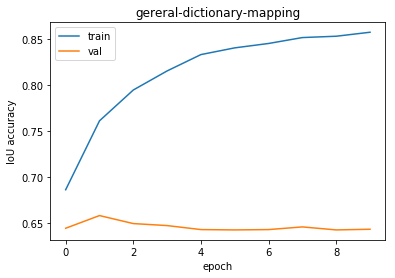

In [33]:
import matplotlib.pyplot as plt
plt.xlabel('epoch')
plt.ylabel('IoU accuracy')
plt.title('gereral-dictionary-mapping')
plt.plot(process['train_IoU_acc_before_refinement'], label='train')
plt.plot(process['val_IoU_acc_before_refinement'], label='val')
plt.legend()

## Plot bounding boxes

In [21]:
import PIL
from PIL import Image, ImageDraw
import os

def draw_bounding_box(filepath_sourceimage, bbox, color, output_dir="", output_name=""):
    """
    Arguemnts:
        filepath: the path to the image file.
        bbox: a 4-element list to describe a bounding box; format: [x1,y1,x2,y2]
        color: a 3-element tuple or a string to describe a color. Example(pure red): (255,0,0) or "#ff0000" or "red"
    """
    img_name = os.path.basename(filepath_sourceimage)

    if isinstance(color, str):
        color = PIL.ImageColor.getrgb(color)

    img = Image.open(filepath_sourceimage).convert("RGBA")
    tmp = Image.new('RGBA', img.size, (0,0,0,0))
    draw = ImageDraw.Draw(tmp)
    draw.rectangle(bbox, fill=color+(32,), outline=color, width=2)
    img = Image.alpha_composite(img, tmp)
    img = img.convert("RGB") # Remove alpha for saving
    if output_name == "":
        out_img_name = 'bbox_' + img_name
    else:
        out_img_name = output_name
    output_path = os.path.join(output_dir, out_img_name)
    img.save(output_path)
    return output_path

In [22]:
def draw_multiple_bounding_boxes(filepath_sourceimage, bbox_color_tuple_list, output_dir="", output_name=""):
    """
    Arguemnts:
        filepath: the path to the image file.
        bbox_color_tuple_list: a list of (bbox, color) tuple, where
            bbox: a 4-element list to describe a bounding box; format: [x1,y1,x2,y2]
            color: a 3-element tuple or a string to describe a color. Example(pure red): (255,0,0) or "#ff0000" or "red"
    """
    img_name = os.path.basename(filepath_sourceimage)
    
    img = Image.open(filepath_sourceimage).convert("RGBA")
    
    
    for bbox, color in bbox_color_tuple_list:
        if isinstance(color, str):
            color = PIL.ImageColor.getrgb(color)
        tmp = Image.new('RGBA', img.size, (0,0,0,0))
        draw = ImageDraw.Draw(tmp)
        draw.rectangle(bbox, fill=color+(32,), outline=color, width=2)
        img = Image.alpha_composite(img, tmp)
        
    img = img.convert("RGB") # Remove alpha for saving
    if output_name == "":
        out_img_name = 'bbox_' + img_name
    else:
        out_img_name = output_name     
    output_path = os.path.join(output_dir, out_img_name)
    img.save(output_path)
    return output_path

In [23]:
phase = "test"

folder = "./test-visualization/"



if not os.path.exists(folder):
    os.mkdir(folder)

if phase == 'val':
    generator_for_visualization = data.DataLoader(validation_set, shuffle=False, batch_size=64)
elif phase == 'test':
    generator_for_visualization = data.DataLoader(test_set, shuffle=False, batch_size=64)

fr_vocab = len(training_corpus_dct.token2id)
model_test = DDPN(cfg, vocab_size=fr_vocab)

#model_en.load_state_dict(torch.load(english_pretrained_model_path, map_location=device))
#model_to_test_path = os.path.join(output_dir, "checkpoint_1.tar")
model_to_test_path = '/media/dongwenjian/SSDBACKUP/newly_added/new_experiments/experiments1/2020-07-04_19-42-40_5k_all-trainable_general-dictionary-mapping/checkpoint_0.tar' 
checkpoint = torch.load(model_to_test_path, map_location=device)
model_test.load_state_dict(checkpoint['model_state_dict'])

model_test.to(device)




DDPN(
  (embedding): Embedding(3112, 300)
  (lstm): LSTM(300, 1024)
  (fc1): Linear(in_features=3077, out_features=512, bias=True)
  (fc_rank): Linear(in_features=512, out_features=1, bias=True)
  (batchnorm): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (softmax): Softmax(dim=1)
)

In [39]:
len(generator_for_visualization)

44

In [46]:
# Draw images in a selected batch

print("loaded checkpoint:", model_to_test_path)


with torch.no_grad():
        
    batch_number = 1 # batch_number begins by 0, until last batch in the data set

    #for inputs, gt_bboxes in generator:
    it = iter(generator_for_visualization)
    for i in range(batch_number+1):
        inputs, gt_bboxes, IDs = next(it)
    Xs, queries = inputs
    img_ids, obj_ids, img_ws, img_hs = IDs
    #print("val_batch_counter", val_batch_counter)
    #print("Xs", Xs.size())
    #print("queries", len(queries))
    #print("gt_bboxes", gt_bboxes.size())

    Qs, seq_lengths = preprocess_query(queries, training_corpus_dct)

    model_test.eval()

    Xs, Qs, gt_bboxes = Xs.to(device), Qs.to(device), gt_bboxes.to(device)

    pred = model_test(Xs, Qs, seq_lengths)
    targ = (get_softlable(Xs, gt_bboxes), gt_bboxes)
    #loss = loss_func_testing(pred, targ)
    loss = loss_func(pred, targ)
    print(loss.item())


    # Statistics of IoU score

    s, t = pred
    proposal_chosen = torch.argmax(s, dim=1)
    batch_size = Xs.size()[0]
    gt_bboxes = gt_bboxes.unsqueeze(1) # add a dimension 1 at the middle is to use the function IoU
    bboxes_chosen_original = Xs[torch.arange(batch_size),proposal_chosen,-5:-1].unsqueeze(1)
    #bboxes_chosen_refined = t[torch.arange(batch_size),proposal_chosen,:].unsqueeze(1)
    #print(bboxes_chosen.size())
    ious_original = IoU(bboxes_chosen_original, gt_bboxes).squeeze()  
    #ious_refined = IoU(bboxes_chosen_refined, gt_bboxes).squeeze() 
    
    
    def get_bbox_in_original_scale(boxes, img_ws, img_hs, sample_in_batch):
        box = boxes[sample_in_batch].tolist()[0]  # [0] is to remove a pair of []
        #print(box)
        #print(img_ws[sample_in_batch])
        #print(img_hs[sample_in_batch])
        #print(img_ws[sample_in_batch].data.cpu().numpy())
        box[0] *= img_ws[sample_in_batch].item()
        box[1] *= img_hs[sample_in_batch].item()
        box[2] *= img_ws[sample_in_batch].item()
        box[3] *= img_hs[sample_in_batch].item()
        #print("box[0]", box[0])
        return box
    
    for sample_in_batch in range(0,batch_size): # draw different samples within the selected batch. Attention, if you want to change batch, you should not change this line, but change batch_number above

        gt_box = get_bbox_in_original_scale(gt_bboxes, img_ws, img_hs, sample_in_batch)
        top_rank_box = get_bbox_in_original_scale(bboxes_chosen_original, img_ws, img_hs, sample_in_batch)
        #refined_top_rank_box = get_bbox_in_original_scale(bboxes_chosen_refined, img_ws, img_hs, sample_in_batch)

#         boxes_colors = [(gt_box, "green"),
#                         (top_rank_box, "yellow"),
#                         (refined_top_rank_box, "red")
#                         ]

        boxes_colors = [(gt_box, "green"),
                        (top_rank_box, "yellow"),
                        ]

        img_path_source = os.path.join(img_dir, img_ids[sample_in_batch]+'.jpg')  
        query_number = batch_number*batch_size+sample_in_batch
        score_iou = ious_original[sample_in_batch].item()
        flag_success_or_failure = 'S' if score_iou > 0.5 else 'F'
        output_path = draw_multiple_bounding_boxes(img_path_source, boxes_colors, output_dir = folder,
                output_name=str(query_number) + "_" + img_ids[sample_in_batch]+'_'+obj_ids[sample_in_batch]+'_'+queries[sample_in_batch]+ f"_{score_iou:.3f}_" + flag_success_or_failure + '.jpg')
        print(query_number, img_ids[sample_in_batch], obj_ids[sample_in_batch], queries[sample_in_batch], score_iou, flag_success_or_failure)

#os.system("xdg-open "+output_path)



loaded checkpoint: /media/dongwenjian/SSDBACKUP/newly_added/new_experiments/experiments1/2020-07-04_19-42-40_5k_all-trainable_general-dictionary-mapping/checkpoint_0.tar
1.2634735107421875
64 1153704539 4035 la trompette 0.7450123429298401 S
65 1153704539 4037 le terrain 0.765592634677887 S
66 1159381599 4149 une femme 0.7870442271232605 S
67 1159381599 4149 un saut périlleux 0.7870442271232605 S
68 1159381599 4150 un trampoline 0.7702390551567078 S
69 1167908324 4435 un homme 0.7610761523246765 S
70 1167908324 4436 une série de jeux vidéo 0.5676625370979309 S
71 1181708011 4630 une femme 0.8400163650512695 S
72 1181708011 4632 une perceuse 0.2084028124809265 F
73 1181708011 4634 un autre homme 0.055720292031764984 F
74 118865844 4847 une femme 0.6063265204429626 S
75 118865844 4849 sweat rose 0.6866416335105896 S
76 118865844 4852 tablier 0.17156334221363068 F
77 118865844 4848 une table 0.7482868432998657 S
78 118865844 4850 une éponge 0.8316717147827148 S
79 121178216 5305 un homme 

In [24]:
# Draw all images in entire set

print("loaded checkpoint:", model_to_test_path)

def get_bbox_in_original_scale(boxes, img_ws, img_hs, sample_in_batch):
    box = boxes[sample_in_batch].tolist()[0]  # [0] is to remove a pair of []
    #print(box)
    #print(img_ws[sample_in_batch])
    #print(img_hs[sample_in_batch])
    #print(img_ws[sample_in_batch].data.cpu().numpy())
    box[0] *= img_ws[sample_in_batch].item()
    box[1] *= img_hs[sample_in_batch].item()
    box[2] *= img_ws[sample_in_batch].item()
    box[3] *= img_hs[sample_in_batch].item()
    #print("box[0]", box[0])
    return box    

with torch.no_grad():
        
    batch_number = 1 # batch_number begins by 0, until last batch in the data set

    for batch_number, (inputs, gt_bboxes, IDs) in enumerate(generator_for_visualization):
    
        Xs, queries = inputs
        img_ids, obj_ids, img_ws, img_hs = IDs

        Qs, seq_lengths = preprocess_query(queries, training_corpus_dct)

        model_test.eval()

        Xs, Qs, gt_bboxes = Xs.to(device), Qs.to(device), gt_bboxes.to(device)

        pred = model_test(Xs, Qs, seq_lengths)
        targ = (get_softlable(Xs, gt_bboxes), gt_bboxes)
        loss = loss_func(pred, targ)
        print(loss.item())


        # Statistics of IoU score

        s, t = pred
        proposal_chosen = torch.argmax(s, dim=1)
        batch_size = Xs.size()[0]
        gt_bboxes = gt_bboxes.unsqueeze(1) # add a dimension 1 at the middle is to use the function IoU
        bboxes_chosen_original = Xs[torch.arange(batch_size),proposal_chosen,-5:-1].unsqueeze(1)
        #bboxes_chosen_refined = t[torch.arange(batch_size),proposal_chosen,:].unsqueeze(1)
        #print(bboxes_chosen.size())
        ious_original = IoU(bboxes_chosen_original, gt_bboxes).squeeze()  
        #ious_refined = IoU(bboxes_chosen_refined, gt_bboxes).squeeze() 


        

        for sample_in_batch in range(0,batch_size): # draw different samples within the selected batch. Attention, if you want to change batch, you should not change this line, but change batch_number above

            gt_box = get_bbox_in_original_scale(gt_bboxes, img_ws, img_hs, sample_in_batch)
            top_rank_box = get_bbox_in_original_scale(bboxes_chosen_original, img_ws, img_hs, sample_in_batch)
            #refined_top_rank_box = get_bbox_in_original_scale(bboxes_chosen_refined, img_ws, img_hs, sample_in_batch)

    #         boxes_colors = [(gt_box, "green"),
    #                         (top_rank_box, "yellow"),
    #                         (refined_top_rank_box, "red")
    #                         ]

            boxes_colors = [(gt_box, "green"),
                            (top_rank_box, "yellow"),
                            ]

            img_path_source = os.path.join(img_dir, img_ids[sample_in_batch]+'.jpg')  
            query_number = batch_number*batch_size+sample_in_batch
            score_iou = ious_original[sample_in_batch].item()
            flag_success_or_failure = 'S' if score_iou > 0.5 else 'F'
            output_path = draw_multiple_bounding_boxes(img_path_source, boxes_colors, output_dir = folder,
                    output_name=str(query_number) + "_" + img_ids[sample_in_batch]+'_'+obj_ids[sample_in_batch]+'_'+queries[sample_in_batch]+ f"_{score_iou:.3f}_" + flag_success_or_failure + '.jpg')
            print(query_number, img_ids[sample_in_batch], obj_ids[sample_in_batch], queries[sample_in_batch], score_iou, flag_success_or_failure)

    #os.system("xdg-open "+output_path)



loaded checkpoint: /media/dongwenjian/SSDBACKUP/newly_added/new_experiments/experiments1/2020-07-04_19-42-40_5k_all-trainable_general-dictionary-mapping/checkpoint_0.tar
1.156495213508606
0 1007129816 203 un homme 0.687237024307251 S
1 1007129816 204 un chapeau orange 0.5830293893814087 S
2 1009434119 271 un terrier de boston 0.666776180267334 S
3 1009434119 272 l' herbe verdoyante 0.7659299969673157 S
4 1009434119 273 une clôture blanche 0.6913732290267944 S
5 101362133 432 une fille 0.36350229382514954 F
6 101362133 441 karaté 0.607223629951477 S
7 101362133 435 un bâton 0.5772474408149719 S
8 102617084 737 cinq personnes 0.6113708019256592 S
9 102617084 749 des vestes d' hiver 0.4663655757904053 F
10 102617084 738 des casques 0.3181712329387665 F
11 102617084 740 la neige 0.7122679352760315 S
12 102617084 742 des motoneiges 0.4654296040534973 F
13 10287332 820 des gens 0.5941346287727356 S
14 10287332 824 le toit d' une maison 0.7802619934082031 S
15 1039637574 1042 un homme 0.74343

156 1408554531 11628 une femme 0.5895673036575317 S
157 1408554531 11632 jean 0.7226886749267578 S
158 1408554531 11630 une publicité 0.0 F
159 1408554531 11631 une femme 0.09724785387516022 F
160 1408554531 11633 ses lunettes de soleil 0.25169816613197327 F
161 14133592 11890 un homme 0.48831745982170105 F
162 14133592 11892 polo rose 0.5176359415054321 S
163 14133592 11894 l' herbe 0.7827573418617249 S
164 14133592 11891 un ballon 0.4985065162181854 F
165 1414911626 11984 une voiture 0.6974099278450012 S
166 1414911626 11985 la plage 0.839468240737915 S
167 1417882092 12142 deux hommes 0.801692545413971 S
168 1417882092 12143 noir 0.646813690662384 S
169 1433088025 12753 l' homme 0.636261522769928 S
170 1433088025 12754 pantalon jaune 0.8722328543663025 S
171 1433088025 12760 les bras 0.2630583941936493 F
172 14559446 13517 deux hommes 0.6287975907325745 S
173 14559446 13521 des casquettes 0.019565483555197716 F
174 14559446 13520 des bâtons de marche 0.0 F
175 14559446 13518 une éte

311 2052202553 25962 un bâton 0.6990469098091125 S
312 2063399864 26524 une mère 0.050413452088832855 F
313 2063399864 26525 ses deux jeunes garçons 0.3521396517753601 F
314 2063399864 26535 une eau très bleue 0.6404901146888733 S
315 2063399864 26526 une côte rocheuse 0.30950140953063965 F
316 2064046067 26566 un enfant 0.790751576423645 S
317 2064046067 26567 de chaises rouges 0.5539601445198059 S
318 2064792226 26601 une fille 0.8240991234779358 S
319 2064792226 26602 un vélo décoré 0.6266934275627136 S
1.012892723083496
320 2064792226 26603 un jeune garçon 0.7558499574661255 S
321 2064792226 26604 une autre fille 0.3475249111652374 F
322 2066271441 26679 un chien noir 0.5990579128265381 S
323 2066271441 26681 une balle 0.7375606298446655 S
324 2066271441 26680 l' eau 0.6129397749900818 S
325 2069110603 26778 un homme 0.5567322373390198 S
326 2069110603 26785 pantalon blanc 0.9229739904403687 S
327 2069110603 26779 t-shirt bleu 0.7495856285095215 S
328 2069110603 26780 un punching-b

465 2391269207 45954 un chien 0.5898689031600952 S
466 2391269207 45955 un jouet jaune 0.7017490863800049 S
467 2392625002 46067 un chien 0.593131959438324 S
468 2392625002 46068 une couverture 0.7176162004470825 S
469 2407470303 46913 une famille 0.8562841415405273 S
470 2407470303 46915 la plage 0.7304909229278564 S
471 2407470303 46914 leur chien 0.7127993106842041 S
472 2415587549 47783 une femme 0.09792677313089371 F
473 2415587549 47784 un enfant 0.8880952596664429 S
474 2415587549 47784 l' enfant 0.8880952596664429 S
475 2421340833 48117 deux hommes 0.6796579360961914 S
476 2421340833 48115 une femme 0.2843598425388336 F
477 2421367904 48119 un groupe d' hommes 0.48854759335517883 F
478 2421367904 48126 des troncs 0.3585030734539032 F
479 2421367904 48120 l' eau 0.8135017156600952 S
480 2422589651 48225 un homme 0.6490012407302856 S
481 2422589651 48229 un verre à pied 0.5311998724937439 S
482 2422589651 48228 le journal 0.5942678451538086 S
483 2424250856 48431 un homme [ 0.772

620 2671560649 65269 un garçon 0.7137671709060669 S
621 2671560649 65271 un télescope 0.0 F
622 2673209105 65363 une jeune fille pieds nus 0.6383457183837891 S
623 2673209105 65365 robe rose 0.7787060141563416 S
624 2678668581 65672 beaucoup de gens 0.12308183312416077 F
625 2678668581 65673 une tente dehors 0.48605549335479736 F
626 2679382388 65745 un jeune 0.7352108955383301 S
627 2679382388 65747 un t-shirt noir [ 0.8351079821586609 S
628 2679382388 65749 la percussion 0.5513334274291992 S
629 2686849571 66139 un homme 0.8399961590766907 S
630 2686849571 66148 des objets 0.0 F
631 2686849571 66144 bord de la route 0.7422885894775391 S
632 2689001252 66334 la fille 0.31458958983421326 F
633 2689001252 66337 jaune 0.6841560006141663 S
634 2689001252 66335 la fille 0.0 F
635 2689001252 66339 orange 0.778674840927124 S
636 2689001252 66336 la fille 0.0 F
637 2689001252 66341 bleu 0.20768144726753235 F
638 2695961935 66638 un chien 0.723495364189148 S
639 2695961935 66639 un obstacle de

776 286084055 77382 deux femmes 0.8032252192497253 S
777 286084055 77383 vin blanc 0.18786214292049408 F
778 2863539038 77538 un homme asiatique 0.8022762537002563 S
779 2863539038 77539 la nourriture 0.6997137665748596 S
780 2867026654 77759 un chien brun 0.7070608735084534 S
781 2867026654 77760 un frisbee vert 0.8683506846427917 S
782 2867460039 77783 des fans 0.7925226092338562 S
783 2867460039 77781 le groupe 0.10888225585222244 F
784 2869439070 77909 un jeune garçon 0.6518279314041138 S
785 2869439070 77910 une sculpture en sable représentant une pyramide 0.711401104927063 S
786 2870426310 77948 trois jeunes enfants 0.6710823178291321 S
787 2870426310 77949 la pelouse d' un jardin 0.7922813892364502 S
788 2872099696 78039 un homme 0.7050620913505554 S
789 2872099696 78041 une œuvre d' art 0.8506653308868408 S
790 2872099696 78046 un chariot 0.5602896213531494 S
791 2873252292 78147 un homme 0.49426838755607605 F
792 2873252292 78148 un vélo 0.6991053223609924 S
793 2889845164 792

925 3051972592 90306 un officier de l' armée 0.5972186923027039 S
926 3051972592 90308 quelque chose 0.8237451314926147 S
927 3052436578 90386 une mariée 0.3082861602306366 F
928 3052436578 90387 un époux 0.714073657989502 S
929 3052436578 90389 le voile de la mariée 0.07449840754270554 F
930 3064443326 91049 la police antiémeute 0.0 F
931 3064443326 91041 un jeune homme 0.5793370604515076 S
932 3064443326 91042 un foulard rouge 0.5202541947364807 S
933 3064443326 91043 le visage 0.26966509222984314 F
934 3064716525 91062 un chien noir et blanc 0.7207391858100891 S
935 3064716525 91064 un obstacle 0.08530712127685547 F
936 3070836317 91414 une femme 0.6031109690666199 S
937 3070836317 91419 un pull 0.716332197189331 S
938 3070836317 91417 un livre [ 0.6325962543487549 S
939 3072673694 91483 plusieurs adolescents 0.4620164930820465 F
940 3072673694 91485 une rambarde 0.35257837176322937 F
941 3078844565 91764 l' homme 0.7216478586196899 S
942 3078844565 91766 t-shirt blanc 0.80473744869

1071 3277162496 106388 trois chiens 0.5854314565658569 S
1072 3278581900 106480 deux jeunes enfants 0.7869454622268677 S
1073 327955368 106548 un jeune garçon souriant 0.5230444669723511 S
1074 327955368 106550 les feuilles 0.582597017288208 S
1075 327955368 106549 les canards 0.783538281917572 S
1076 3283368342 106804 ces quatre personnes 0.672522246837616 S
1077 3283368342 106806 3 chiens 0.2500036060810089 F
1078 3285342629 106930 les ruines mayas 0.04031996801495552 F
1079 3285342629 106931 un guide 0.18481948971748352 F
1080 3286543624 107046 une fille 0.918737530708313 S
1081 3286543624 107047 un t-shirt radio 0.8225178122520447 S
1082 3286543624 107052 la bouche ouverte 0.5931137204170227 S
1083 3288174272 107158 un groupe tribal 0.709644079208374 S
1084 3288174272 107160 des bidons d' eau 0.0 F
1085 3293751640 107470 un homme 0.797461748123169 S
1086 3294830188 107548 une nuée d' oiseaux 0.129411518573761 F
1087 3294830188 107550 de la nourriture 0.0023801391944289207 F
1.09370

1.1490862369537354
1216 3504379699 123366 un arbre 0.8072929382324219 S
1217 3512747808 123833 deux femmes 0.9199701547622681 S
1218 3512747808 123835 les mains 0.4302000105381012 F
1219 3512747808 123834 une table 0.33483871817588806 F
1220 3514194772 123976 un chien brun haletant 0.7825645804405212 S
1221 3514194772 123977 la pelouse 0.8183628916740417 S
1222 3514278386 123980 une joueuse de baseball 0.03509814664721489 F
1223 3514278386 123988 maillot noir 0.6909055113792419 S
1224 3514278386 123983 une joueuse 0.032115619629621506 F
1225 3514278386 123989 maillot blanc 0.7020049095153809 S
1226 3514685438 124013 une femme 0.719702422618866 S
1227 3514685438 124015 un gros chèque 0.8703188896179199 S
1228 3514685438 124014 kids food basket 0.12597593665122986 F
1229 3525403875 124812 les deux chiens 0.6496741771697998 S
1230 3525403875 124816 un 0.337433397769928 F
1231 3525403875 124813 une balle de tennis 0.8935229778289795 S
1232 3525403875 124815 sa gueule 0.0 F
1233 3525403875 

1361 3694555931 137475 une pataugeoire 0.8187664747238159 S
1362 3700739661 137851 un gars 0.6411101818084717 S
1363 3700739661 137856 t-shirt blanc 0.701918363571167 S
1364 3700739661 137853 une 0.01117143128067255 F
1365 3700739661 137861 la main 0.0 F
1366 3701291852 137884 deux personnes 0.8370119333267212 S
1367 3701291852 137885 un lac 0.17114312946796417 F
1368 3712574653 138768 plusieurs personnes 0.7426576614379883 S
1369 3712574653 138771 une table 0.601107656955719 S
1370 3712574653 138773 tenues de cérémonie 0.5099920034408569 S
1371 3715669736 139024 deux filles 0.6493644714355469 S
1372 3715669736 139025 bleu 0.9094992280006409 S
1373 3715669736 139027 une 0.24513134360313416 F
1374 3715669736 139026 rose 0.5961838960647583 S
1375 3715669736 139031 rollers 0.35778218507766724 F
1376 3716244806 139086 les quatre personnes 0.3783353567123413 F
1377 3717309680 139161 un groupe de personnes 0.4598449468612671 F
1378 3717309680 139166 des motos 0.4701749384403229 F
1379 372108

1507 400598822 151687 de la viande 0.2862491309642792 F
1508 400598822 151689 un gril dehors 0.7707912921905518 S
1509 4031513473 152615 deux hommes 0.32261937856674194 F
1510 4031513473 152617 des fruits 0.046273112297058105 F
1511 4035354150 152757 une femme brune 0.44582149386405945 F
1512 4035354150 152758 bikini blanc 0.16416367888450623 F
1513 4035354150 152759 une boisson 0.0 F
1514 4035354150 152761 le gobelet d' un homme 0.03506983444094658 F
1515 4039846249 152883 un garçon 0.688422441482544 S
1516 4039846249 152885 des lunettes de soleil 0.4802566170692444 F
1517 4043318461 153010 une main gantée 0.6848565340042114 S
1518 4043318461 153013 un clou surdimensionné 0.27412670850753784 F
1519 4043318461 153007 un tronc 0.879572331905365 S
1520 4046112444 153193 un homme 0.668681263923645 S
1521 4046112444 153195 chemise à carreaux 0.7096409201622009 S
1522 4046112444 153194 une paire de gants noirs 0.4206390380859375 F
1523 405556084 153576 deux hommes 0.6579259634017944 S
1524 

1654 4418969015 167031 une tribu africaine 0.7877771854400635 S
1655 4418969015 167040 la forêt 0.12347391992807388 F
1656 4420174290 167098 une jeune fille 0.8242564797401428 S
1657 4420174290 167099 une chèvre 0.4712962508201599 F
1658 4427860005 167284 des asiatiques 0.965415894985199 S
1659 4427860005 167286 des chaises jaunes 0.10297300666570663 F
1660 442983801 167375 une petite fille 0.6472064256668091 S
1661 442983801 167377 un cookie 0.06856205314397812 F
1662 442983801 167378 une chaise haute 0.7010983824729919 S
1663 442983801 167376 un bavoir 0.6718854308128357 S
1.2738021612167358
1664 4434125934 167699 un homme aux cheveux gris 0.012513591907918453 F
1665 4434125934 167703 des gants noirs 0.4146694242954254 F
1666 4434125934 167700 la pelouse 0.7321140170097351 S
1667 4434578571 167727 une femme 0.0 F
1668 4434578571 167728 un livre 0.5440054535865784 S
1669 4434578571 167731 une rangée de fauteuils rouges 0.5299934148788452 S
1670 4439439741 168197 un enfant 0.6636378765

1800 4563143284 178772 des lunettes de soleil 0.538734495639801 S
1801 4563143284 178769 un engin de construction 0.6406256556510925 S
1802 4563143284 178770 gravier 0.3685804605484009 F
1803 4567311889 179217 un bébé 0.8902953863143921 S
1804 4567311889 179220 ses jouets 0.46323996782302856 F
1805 4567311889 179218 un chat noir et blanc 0.8622606992721558 S
1806 4567455846 179263 une adolescente 0.3827976584434509 F
1807 4567455846 179264 une guitare 0.7238166928291321 S
1808 4578856261 180138 un homme 0.7237187027931213 S
1809 4578856261 180139 un sac à dos 0.5496919751167297 S
1810 4578856261 180141 la rue 0.6899111866950989 S
1811 4587060991 180628 deux hommes 0.6436665654182434 S
1812 4587837067 180710 une femme 0.6837570667266846 S
1813 4587837067 180711 noir 0.6482453942298889 S
1814 4587837067 180714 quelque chose 0.0 F
1815 4587837067 180713 sa bouche 0.06156888231635094 F
1816 4587901777 180751 un groupe de personnes 0.532859742641449 S
1817 4587901777 180752 une petite table

1947 4733026480 196733 t-shirt rouge 0.05099833384156227 F
1948 4733026480 196732 la foule qui passe 0.2847529947757721 F
1949 4735200580 196987 un garçon 0.5874295830726624 S
1950 4735200580 196989 short blanc 0.7870908975601196 S
1951 4735200580 196988 un lac ou une rivière 0.5408897995948792 S
1952 4736841029 197164 une petite fille 0.7960121035575867 S
1953 4736841029 197166 un télescope 0.3308783769607544 F
1954 4739632460 197462 plusieurs ouvriers du bâtiment 0.6235347986221313 S
1955 4739632460 197467 gilets de sécurité oranges 0.6209297180175781 S
1956 4742299638 197750 une personne 0.7016291618347168 S
1957 4742299638 197753 sweat à capuche 0.2583492398262024 F
1958 4742299638 197757 un bâtiment 0.6873000264167786 S
1959 4745356451 198035 des ouvriers du bâtiment 0.6118307709693909 S
1960 474581065 198070 un homme 0.5341914296150208 S
1961 474581065 198073 un cheval de course 0.5758345723152161 S
1962 474581065 198071 d' autres hommes 0.7758918404579163 S
1963 4751250311 19859

2090 4814603619 206135 le pont vert 0.8547663688659668 S
2091 4814933116 206217 une femme 0.4955087900161743 F
2092 4814933116 206220 une serviette 0.0 F
2093 4814933116 206224 des gens 0.7212367057800293 S
2094 4814933116 206221 l' eau bleue 0.8752806782722473 S
2095 481632457 206344 un berger australien adulte 0.08858539909124374 F
2096 481632457 206343 un petit berger australien 0.5746414065361023 S
2097 4817447781 206503 des clients 0.6198101043701172 S
2098 4817447781 206504 des amateurs de cuisine de bistrot 0.2674024701118469 F
2099 4818429638 206701 l' homme afro-américain 0.04123377054929733 F
2100 4821487527 207090 un policier 0.46056580543518066 F
2101 4821487527 207091 une moto 0.786863386631012 S
2102 4821487527 207092 le feu 0.04844975098967552 F
2103 4823948097 207412 un groupe d' hommes 0.7670221924781799 S
2104 4823948097 207413 une table 0.2687230706214905 F
2105 4824522315 207524 un groupe d' entrepreneurs de la haute société 0.5851088166236877 S
2106 4824522315 2075

2238 4952001654 222617 le pavé 0.6079011559486389 S
2239 4952001654 222611 un objet 0.0 F
1.5491352081298828
2240 4952694407 222675 plusieurs personnes 0.6913153529167175 S
2241 4952694407 222680 blouses bleues 0.6767184734344482 S
2242 4952694407 222676 une 0.11435408890247345 F
2243 4952694407 222679 jupe 0.4346845746040344 F
2244 4952694407 222678 chemisier noir 0.680061399936676 S
2245 4953536921 222764 une femme 0.7082602381706238 S
2246 4953536921 222767 un chien 0.6940513253211975 S
2247 4953536921 222766 un banc blanc 0.46067267656326294 F
2248 4953536921 222765 une plage 0.2415333390235901 F
2249 4954827712 222916 deux femmes 0.6547521948814392 S
2250 4954827712 222918 la terre 0.005684732925146818 F
2251 4954827712 222919 un grand bâtiment 0.59321528673172 S
2252 4965629392 223981 un groupe d' hommes 0.4566477835178375 F
2253 4965629392 223982 un enfant 0.9399631023406982 S
2254 4965629392 223973 t-shirts blancs 0.0738477110862732 F
2255 4965629392 223980 la route 0.604403138

2385 5510073103 237934 un tablier 0.42896580696105957 F
2386 5510073103 237935 des saucisses 0.5911713242530823 S
2387 5519356488 238150 un clown 0.6737700700759888 S
2388 5522182662 238207 le capitaine souriant 0.4859706461429596 F
2389 5522182662 238208 le gouvernail de son bateau en bois 0.5569684505462646 S
2390 5566972 238877 un bulldozer 0.13004733622074127 F
2391 5566972 238878 la terre 0.0 F
2392 5584269779 239122 une femme 0.5844767093658447 S
2393 5584269779 239124 veste rouge 0.7670565247535706 S
2394 5584269779 239123 un cheval tout blanc [ 0.7499436736106873 S
2395 5584269779 239126 des arbres 0.7126440405845642 S
2396 5615068475 239739 une femme 0.6885658502578735 S
2397 5615068475 239742 un très gros rocher 0.6565958857536316 S
2398 5615068475 239746 des arbres 0.805289626121521 S
2399 5622966650 239940 trois hommes 0.6703891754150391 S
2400 5622966650 239942 costumes de couleur vive 0.6085518598556519 S
2401 5622966650 239961 la rue 0.8470982909202576 S
2402 5622966650 

2535 651277216 255122 une femme 0.7003141641616821 S
2536 651277216 255125 un enfant 0.6123245358467102 S
2537 651277216 255126 une rue 0.7502393126487732 S
2538 6515331737 255145 trois femmes 0.5918154716491699 S
2539 6515331737 255147 des ballons 0.13467317819595337 F
2540 6515331737 255146 l' herbe 0.6465932130813599 S
2541 6556870225 255618 un garçon afro-américain 0.8709238767623901 S
2542 6556870225 255625 un short bleu 0.7437307834625244 S
2543 6556870225 255621 un t-shirt rouge et noir 0.7091805934906006 S
2544 6556870225 255625 des tennis blanches 0.7437307834625244 S
2545 6563291133 255732 un homme 0.8026069402694702 S
2546 6563291133 255734 une femme 0.8543099164962769 S
2547 6563291133 255740 hauts blancs [ 0.3390333354473114 F
2548 6586954247 255915 un homme 0.8566396832466125 S
2549 6586954247 255917 une famille 0.6180576086044312 S
2550 6586954247 255918 une espèce de sonde 0.3466701805591583 F
2551 6589292543 255939 un très jeune garçon 0.566801130771637 S
2552 65892925

2682 76485985 272653 deux filles 0.6230956315994263 S
2683 76485985 272658 leurs mains 0.03278375044465065 F
2684 76485985 272654 une fontaine 0.5828266143798828 S
2685 76485985 272663 des gens 0.23932291567325592 F
2686 766061382 272848 un enfant mouillé 0.731937825679779 S
2687 766061382 272851 les bras 0.3398233652114868 F
1.1443991661071777
2688 7670346004 273047 deux hommes 0.7063606977462769 S
2689 7670346004 273046 un 0.4039258360862732 F
2690 7670346004 273050 blanc 0.36033645272254944 F
2691 7670346004 273049 l' autre 0.6097117066383362 S
2692 7670346004 273048 bleu 0.5860425233840942 S
2693 7694340978 273472 une femme 0.5452401041984558 S
2694 7694340978 273475 bikini rouge 0.4833570718765259 F
2695 7694340978 273473 un ballon 0.7826306223869324 S
2696 771048251 273805 un chaton à rayures oranges 0.6786115169525146 S
2697 771048251 273806 le nez 0.0 F
2698 771048251 273804 une fille blonde 0.7612911462783813 S
2699 7738684358 274367 une femme 0.14875642955303192 F
2700 773868

IndexError: index 37 is out of bounds for dimension 0 with size 37

## Utility

### draw all bounding box proposals on one image to visualize an intermediate result

In [ ]:
# This block is to draw all bounding box proposals on one image.  

visualization_dir = "./visualization_gt2/"


if not os.path.exists(visualization_dir):
    os.mkdir(visualization_dir)

validation_generator_for_visualization = data.DataLoader(validation_set, shuffle=False, batch_size=64)


batch_number = 1 # batch_number begins by 0, until last batch in validation set

#for inputs, gt_bboxes in validation_generator:
it = iter(validation_generator_for_visualization)
for i in range(batch_number+1):
    inputs, gt_bboxes, IDs = next(it)
Xs, queries = inputs
img_ids, obj_ids, img_ws, img_hs = IDs
#print("val_batch_counter", val_batch_counter)
#print("Xs", Xs.size())
#print("queries", len(queries))



def get_bbox_in_original_scale_all_proposals(boxes, img_ws, img_hs, sample_in_batch):
    #print(boxes)
    box = boxes.clone()
    #print(box[0])
    #print(img_ws[sample_in_batch])
    #print(img_hs[sample_in_batch])
    #print(img_ws[sample_in_batch].data.cpu().numpy())
    box[:,0] *= img_ws[sample_in_batch]
    box[:,1] *= img_hs[sample_in_batch]
    box[:,2] *= img_ws[sample_in_batch]
    box[:,3] *= img_hs[sample_in_batch]
    print("box", box)
    return box.tolist()

for sample_in_batch in range(0,64): # Change here to see a different sample

    sample_in_batch = 0

    proposals = Xs[sample_in_batch,:,-5:-1]
    proposal_list = get_bbox_in_original_scale_all_proposals(proposals, img_ws, img_hs, sample_in_batch)
    
     
    #print(proposal_list[0])
    
    img_path_source = os.path.join(img_dir, img_ids[sample_in_batch]+'.jpg')  
    im = Image.open(img_path_source)
    
    print(len(proposal_list[i]))
    
    for i in range(len(proposal_list)):
        ImageDraw.ImageDraw(im).rectangle(proposal_list[i], outline="yellow", width=0)
        
    query_number = batch_number*batch_size+sample_in_batch
#     output_path = draw_multiple_bounding_boxes(img_path_source, boxes_colors, output_dir = visualization_dir,
#             output_name=str(query_number) + "_" + img_ids[sample_in_batch]+'_'+obj_ids[sample_in_batch]+'_'+queries[sample_in_batch]+'.jpg')
    im.save(os.path.join(visualization_dir, str(query_number) + "_" + img_ids[sample_in_batch]+'_'+obj_ids[sample_in_batch]+'_'+queries[sample_in_batch]+'.jpg'))
    print(query_number, img_ids[sample_in_batch], obj_ids[sample_in_batch], queries[sample_in_batch])
    
    break

### Utilities: for obtaining the general dictionary by google translation

In [27]:
with open(f"./dictionary/FrenchWordList{fr_dataset_volume}.txt", "w") as f:
    for key in training_corpus_dct.token2id:
        f.write(key+'\n')

In [29]:
with open(f"./dictionary/FrenchWordList{fr_dataset_volume}.txt", "r") as f_fr:
    fr_words = f_fr.readlines()
    fr_words = [item.strip() for item in fr_words]  
with open(f"./dictionary/Fr-En-GoogleTrans{fr_dataset_volume}.txt", "r") as f_en:
    en_words = f_en.readlines()
    en_words = [item.strip() for item in en_words]  
    en_words = [item.split(' ')[-1] for item in en_words]  # When it is a phrase, just choose the last word
with open(f"./dictionary/Fr-En-GoogleTrans_dictionary{fr_dataset_volume}.txt", "w") as f_fr2en:
    for i in range(len(fr_words)):
        f_fr2en.write(f"{fr_words[i]} {en_words[i]}\n") 